In [1]:
%%capture
!pip install together

import os
if "COLAB_" in "".join(os.environ.keys()):
  !mkdir data
  !cd data ; wget https://raw.githubusercontent.com/togethercomputer/together-cookbook/refs/heads/datascience-agent/Agents/DataScienceAgent/data/train_and_test2.csv

In [2]:
import os
import re
import json
import textwrap
import base64
from pathlib import Path
from typing import Dict, Optional, List, Any, Union

from together import Together
from IPython.display import Image, display

In [3]:
reasoning_model = "meta-llama/Llama-3.3-70B-Instruct-Turbo"  # Primary model for reasoning and code generation

# Execution Settings
# ------------------
max_iterations = 15  # Maximum number of reasoning cycles
temperature = 0.2    # Lower temperature for more consistent code generation
session_timeout = 3600  # Session timeout in seconds

# Display Settings
# ---------------
max_output_length = 500  # Maximum words in displayed output
show_images = True      # Whether to display generated plots
box_width = 80         # Width of output boxes

# Initialize Together Client
# -------------------------
together_client = Together(api_key="TOGETHER-API-KEY")  # Replace with your API key
code_interpreter = together_client.code_interpreter

In [4]:
# This function executes Python code using Together Code Interpreter and returns the result.
def run_python(code: str, session_id: Optional[str] = None, files: Optional[list[Dict[str, str]]] = None):
    """
    Executes Python code using Together Code Interpreter and returns the result.
    Args:
        code: The Python code to execute
        session_id: Optional session ID to maintain state between executions
        files: Optional list of files to upload to the code interpreter
              Each file should be a dict with 'name', 'encoding', and 'content' keys

    Returns:
        The output of the executed code as a JSON
    """
    try:
        kwargs = {"code": code, "language": "python"}

        if session_id:
            kwargs["session_id"] = session_id

        if files:
            kwargs["files"] = files

        response = code_interpreter.run(**kwargs)

        result = {"session_id": response.data.session_id, "status": response.data.status, "outputs": []}

        for output in response.data.outputs:
            result["outputs"].append({"type": output.type, "data": output.data})

        if response.data.errors:
            result["errors"] = response.data.errors

        return result
    except Exception as e:
        error_result = {"status": "error", "error_message": str(e), "session_id": None}
        return error_result

In [5]:
output = run_python("x = 4\nprint(x)")
session_id = output['session_id']
status = output['status']
outputs = output['outputs']

print(f"Session ID: {session_id}")
print(f"Status: {status}")
print(f"Outputs: {outputs}")

Session ID: ses_CPm1vvC4UbkQRF2ZWYAV2
Status: completed
Outputs: [{'type': 'stdout', 'data': '4\n'}]


In [6]:
# re-using the same session_id (we use the variable x again without re-declaring it)
run_python("x=x*x\nprint(x)", session_id)

{'session_id': 'ses_CPm1vvC4UbkQRF2ZWYAV2',
 'status': 'completed',
 'outputs': [{'type': 'stdout', 'data': '16\n'}]}

## **Utilities**

We define a few utilities here. These are mainly functions for nicer printing and for file management.



#### **File Management**

This will later enable the agent to have access to uploaded files located in the `data` repository for workflows that require custom uploaded data.

In [7]:
def collect_files(directory) -> list[Dict[str, str]]:
    """
    Collects all files from the specified directory and its subdirectories.

    Args:
        directory: The directory to scan for files

    Returns:
        A list of file dictionaries ready for upload to the code interpreter
    """
    files = []
    path = Path(directory)

    if not path.exists():
        print(f"Directory '{directory}' does not exist, skipping file collection")
        return files

    for file_path in Path(directory).rglob("*"):
        if file_path.is_file() and not any(part.startswith(".") for part in file_path.parts):
            try:
                # Handle different file types
                if file_path.suffix.lower() in ['.csv', '.txt', '.json', '.py']:
                    with open(file_path, "r", encoding="utf-8") as f:
                        content = f.read()
                    files.append({
                        "name": str(file_path.relative_to(directory)),
                        "encoding": "string",
                        "content": content
                    })
                elif file_path.suffix.lower() in ['.xlsx', '.xls']:
                    # For Excel files, we'll let pandas handle them in the code
                    print(f"Excel file detected: {file_path.name} - will be handled by pandas")

            except (UnicodeDecodeError, PermissionError) as e:
                print(f"Could not read file {file_path}: {e}")

    return files

#### **Output Processing and Display**

These functions handle the formatting and display of execution results, including plots and data visualizations.

In [8]:
# Images returned from the code interpreter are base64 encoded and need to be decoded and displayed
def display_image(b64_image):
    """Display base64 encoded images from code execution results"""
    decoded_image = base64.b64decode(b64_image)
    display(Image(data=decoded_image))

# This function creates a comprehensive summary of execution result for the model's history.
def get_execution_summary(execution_result: Dict) -> str:
    """
    Create a comprehensive summary of execution result for the model's history.
    This gives the model better context about what happened during code execution.

    Args:
        execution_result: The result dictionary from run_python

    Returns:
        A summary of the execution including status, outputs, and any errors
    """
    if not execution_result:
        return "Execution failed - no result returned"

    # Check execution status
    status = execution_result.get("status", "unknown")
    summary_parts = [f"Execution status: {status}"]

    # Process outputs
    stdout_outputs = []
    display_outputs = []
    other_outputs = []

    if "outputs" in execution_result:
        for output in execution_result["outputs"]:
            output_type = output.get("type", "unknown")
            output_data = output.get("data", "")

            if output_type == "stdout":
                stdout_outputs.append(output_data)
            elif output_type == "display_data":
                if isinstance(output_data, dict):
                    if "image/png" in output_data:
                        display_outputs.append("Generated plot/image")
                    if "text/plain" in output_data:
                        display_outputs.append(f"Display: {output_data['text/plain']}")
                else:
                    display_outputs.append("Generated display output")
            else:
                other_outputs.append(f"{output_type}: {str(output_data)[:100]}")

    # Add stdout outputs
    if stdout_outputs:
        summary_parts.append("Text output:")
        summary_parts.extend(stdout_outputs)

    # Add display outputs (plots, images)
    if display_outputs:
        summary_parts.append("Visual outputs:")
        summary_parts.extend(display_outputs)

    # Add other outputs
    if other_outputs:
        summary_parts.append("Other outputs:")
        summary_parts.extend(other_outputs)

    # Check for errors
    if "errors" in execution_result and execution_result["errors"]:
        summary_parts.append("Errors:")
        summary_parts.extend(execution_result["errors"])

    # If no outputs at all but status is success
    if not stdout_outputs and not display_outputs and not other_outputs and status == "success":
        summary_parts.append("Code executed successfully (no explicit output generated)")

    return "\n".join(summary_parts)

# This function processes the execution result and extracts text outputs and image data.
def process_execution_result(execution_result: Dict) -> tuple[str, List[str]]:
    """
    Process execution result and extract text outputs and image data.

    Args:
        execution_result: The result dictionary from run_python

    Returns:
        tuple: (text_output, list_of_image_data)
    """
    text_outputs = []
    image_data = []

    if execution_result and "outputs" in execution_result:
        for output in execution_result["outputs"]:
            if output["type"] == "stdout":
                text_outputs.append(output["data"])
            elif output["type"] == "display_data":
                # Handle display data (images, plots, etc.)
                if isinstance(output["data"], dict):
                    if "image/png" in output["data"]:
                        image_data.append(output["data"]["image/png"])
                    # Add text representation if available
                    if "text/plain" in output["data"]:
                        text_outputs.append(f"[Display Data] {output['data']['text/plain']}")

    # Join all text outputs
    combined_text = "\n".join(text_outputs) if text_outputs else ""

    return combined_text, image_data

#### **Pretty Printing and Formatting**

These functions create beautiful, readable output boxes for the agent's thoughts and results.

In [9]:
def box_text(text: str, title: Optional[str] = None, emoji: Optional[str] = None) -> str:
    """Create a boxed text with optional title and emoji."""
    # Handle None or empty text
    if not text:
        text = "No output"

    # Limit to 500 words for readability
    words = text.split()
    if len(words) > 500:
        words = words[:500]
        words.append("...")
        text = " ".join(words)

    # Wrap text at specified width
    wrapped_lines = []
    for line in text.split("\n"):
        if len(line) > box_width:
            wrapped_lines.extend(textwrap.wrap(line, width=box_width))
        else:
            wrapped_lines.append(line)

    # Handle empty wrapped_lines
    if not wrapped_lines:
        wrapped_lines = ["No output"]

    width = max(len(line) for line in wrapped_lines)
    width = max(width, len(title) if title else 0)

    if title and emoji:
        title = f" {emoji} {title} "
    elif title:
        title = f" {title} "
    elif emoji:
        title = f" {emoji} "

    result = []
    if title:
        result.append(f"╔{'═' * (width + 2)}╗")
        result.append(f"║ {title}{' ' * (width - len(title) + 2)}║")
        result.append(f"╠{'═' * (width + 2)}╣")
    else:
        result.append(f"╔{'═' * (width + 2)}╗")

    for line in wrapped_lines:
        result.append(f"║ {line}{' ' * (width - len(line))} ║")

    result.append(f"╚{'═' * (width + 2)}╝")
    return "\n".join(result)

def print_boxed(text: str, title: Optional[str] = None, emoji: Optional[str] = None):
    """Print text in a box with optional title and emoji."""
    print(box_text(text, title, emoji))

def print_boxed_execution_result(execution_result: Dict, title: Optional[str] = None, emoji: Optional[str] = None):
    """
    Print execution result in a box and display any images as part of the output.
    """
    text_output, image_data = process_execution_result(execution_result)

    # If we have images, mention them in the text
    if image_data:
        if text_output:
            text_output += f"\n\n[Generated {len(image_data)} plot(s)/image(s) - displayed below]"
        else:
            text_output = f"[Generated {len(image_data)} plot(s)/image(s) - displayed below]"
    elif not text_output:
        text_output = "No text output"

    # Print the boxed text
    print(box_text(text_output, title, emoji))

    # Display images immediately after the box
    if show_images:
        for i, img_data in enumerate(image_data):
            if len(image_data) > 1:
                print(f"\n--- Plot/Image {i+1} ---")
            display_image(img_data)
            if i < len(image_data) - 1:
                print()

## **Building the ReAct Agent**

Now we'll construct the main ReAct agent class that orchestrates the reasoning and acting cycle.

#### **The DataScientist ReAct Loop in Brief**

Our DataScientist operates through a ReAct loop: It receives user input, makes a call to the Large Language Model (LLM), and receives a response. The LLM response is expected to be in one of two formats:

* 1) a thought and action input (Python code), or

* 2) a final answer summarizing the findings.

Our agent parse the thought and action input from the LLM response using a simple string matching. If the response is not in the expected format, it handles the error and continues. If python code is found it is then executed, and the results are displayed and added to the conversation history.

The ReAct loop continues until the task is complete or a maximum number of iterations is reached, allowing our agent to iteratively refine its analysis.







### Core Agent Implementation

In [10]:
class ReActDataScienceAgent:
    def __init__(
        self,
        client,
        session_id: Optional[str] = None,
        model: str = reasoning_model,
        max_iterations: int = max_iterations
    ):
        self.client = client
        self.session_id = session_id
        self.model = model
        self.max_iterations = max_iterations

        self.system_prompt = """
        You are an expert data scientist assistant that follows the ReAct framework (Reasoning + Acting).

        CRITICAL RULES:
        1. Execute ONLY ONE action at a time - this is non-negotiable
        2. Be methodical and deliberate in your approach
        3. Always validate data before advanced analysis
        4. Never make assumptions about data structure or content
        5. Never execute potentially destructive operations without confirmation

        IMPORTANT GUIDELINES:
        - Be explorative and creative, but cautious
        - Try things incrementally and observe the results
        - Never randomly guess (e.g., column names) - always examine data first
        - If you don't have data files, use "import os; os.listdir()" to see what's available
        - When you see "Code executed successfully" or "Generated plot/image", it means your code worked
        - Plots and visualizations are automatically displayed to the user
        - Build on previous successful steps rather than starting over

        WAIT FOR THE RESULT OF THE ACTION BEFORE PROCEEDING.

        You must strictly adhere to this format (you have two options):

        ## Format 1 - For taking an action:

        Thought: Reflect on what to do next. Analyze results from previous steps. Be descriptive about your reasoning,
        what you expect to see, and how it builds on previous actions. Reference specific data points or patterns you've observed.

        Action Input:
        ```python
        <python code to run>
        ```

        ## Format 2 - ONLY when you have completely finished the task:

        Thought: Reflect on the complete process and summarize what was accomplished.

        Final Answer:
        [Provide a comprehensive summary of the analysis, key findings, and any recommendations]

        ## Example for data exploration:

        Thought: I need to start by understanding the structure and contents of the dataset. This will help me determine
        the appropriate analysis approaches. I'll load the data and examine its basic properties including shape, columns,
        data types, and a preview of the actual values.

        Action Input:
        ```python
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        import seaborn as sns

        # Load and examine the dataset
        df = pd.read_csv("data.csv")
        print(f"Dataset shape: {df.shape}")
        print(f"\\nColumn names: {df.columns.tolist()}")
        print(f"\\nData types:\\n{df.dtypes}")
        print(f"\\nFirst few rows:\\n{df.head()}")
        ```
        """

        # we will start adding the system prompt here
        self.history = [{"role": "system", "content": self.system_prompt}]

    def llm_call(self):
        """Make a call to the language model"""
        response = self.client.chat.completions.create(
            model=self.model,
            messages=self.history,
            temperature=temperature,
            stream=False
        )
        return response.choices[0].message.content

    def parse_response(self):
        """Parse the LLM response and extract thought and action input"""
        response = self.llm_call()

        if "Final Answer:" in response:
            final_answer = response.split("Final Answer:")[1].strip()
            return final_answer, None

        if "Thought:" in response and "Action Input:" in response:
            thought = response.split("Thought:")[1].split("Action Input:")[0].strip()

            code_match = re.search(r"```(?:python)?\s*(.*?)\s*```", response, re.DOTALL)
            if code_match:
                action_input = code_match.group(1).strip()
            else:
                print(f"ERROR: No code block found in response:\n{response}")
                raise ValueError("No code block found in the response")
        else:
            thought = "The assistant didn't follow the ReAct format properly."
            action_input = "print('Error: Format not followed by the assistant')"

        return thought, action_input

    def run(self, user_input: str):
        """Execute the main ReAct reasoning and acting loop"""
        self.history.append({"role": "user", "content": user_input})

        current_iteration = 0

        print("🚀 Starting ReAct Data Science Agent")
        print(f"📝 Task: {user_input}")
        print("=" * 80)

        while current_iteration < self.max_iterations:
            try:
                result, action_input = self.parse_response()

                if action_input is None:
                    print_boxed(result, "Final Answer", "🎯")
                    return result

                thought = result
                print_boxed(thought, f"Thought (Iteration {current_iteration + 1})", "🤔")
                print_boxed(action_input, "Action", "🛠️")

                # Execute the code
                execution_result = run_python(action_input, self.session_id)

                # Update session ID if we got a new one
                if execution_result and "session_id" in execution_result:
                    self.session_id = execution_result["session_id"]

                # Display results
                print_boxed_execution_result(execution_result, "Result", "📊")

                # Get summary for agent's history
                execution_summary = get_execution_summary(execution_result)

                # Add to conversation history. We use the "user" role for the observation content.
                # You could also use "tools".
                add_to_history = f"Thought: {thought}\nAction Input:```python\n{action_input}\n```"
                self.history.append({"role": "assistant", "content": add_to_history})
                self.history.append({"role": "user", "content": f"Observation: {execution_summary}"})

                current_iteration += 1
                print("-" * 80)

            except Exception as e:
                print(f"❌ Error in iteration {current_iteration + 1}: {str(e)}")
                # Add error to history and continue
                self.history.append({"role": "user", "content": f"Error occurred: {str(e)}. Please try a different approach."})
                current_iteration += 1

        print(f"⚠️ Maximum iterations ({self.max_iterations}) reached without completion")
        return "Task incomplete - maximum iterations reached"

### Helper Functions for Agent Initialization

In [11]:
def create_agent_with_data(data_dir: Optional[str] = None) -> ReActDataScienceAgent:
    """
    Create a ReAct agent with optional data file upload

    Args:
        query: The data science task to perform
        data_dir: Optional directory containing data files to upload

    Returns:
        Configured ReAct agent ready to run
    """
    session_id = None

    # Handle file uploads if data directory provided
    if data_dir and os.path.exists(data_dir):
        print(f"📁 Collecting files from {data_dir}...")
        files = collect_files(data_dir)

        if files:
            print(f"📤 Found {len(files)} files. Initializing session with uploaded files...")

            # Initialize session with files
            init_result = run_python("print('Session initialized with data files')", None, files)

            if init_result and "session_id" in init_result:
                session_id = init_result["session_id"]
                print(f"✅ Session initialized with ID: {session_id}")
            else:
                print("⚠️ Failed to get session ID, continuing without persistent session")
        else:
            print("📂 No valid files found in directory")

    # Create and return the agent
    agent = ReActDataScienceAgent(
        client=together_client,
        session_id=session_id
    )

    return agent

def run_data_science_task(query: str, data_dir: Optional[str] = None) -> str:
    """
    Convenience function to run a complete data science task

    Args:
        query: The data science task description
        data_dir: Optional directory with data files

    Returns:
        The final result from the agent
    """
    agent = create_agent_with_data(data_dir)
    return agent.run(query)

## Iris Dataset Visualization

🌸 EXAMPLE 1: Iris Dataset Visualization
Task: Load the iris dataset and create a scatter plot of sepal length vs sepal width, colored by species

🚀 Starting ReAct Data Science Agent
📝 Task: Load the iris dataset and create a scatter plot of sepal length vs sepal width, colored by species
╔══════════════════════════════════════════════════════════════════════════════════╗
║  🤔 Thought (Iteration 1)                                                          ║
╠══════════════════════════════════════════════════════════════════════════════════╣
║ To begin analyzing the iris dataset, I want to visualize the relationship        ║
║ between sepal length and sepal width, as these are key characteristics that      ║
║ might distinguish between different species of iris. By coloring the points in   ║
║ the scatter plot by species, I expect to see if there are any clear patterns or  ║
║ clusters that emerge, which could inform further analysis or modeling efforts. I ║
║ will use the popular iris da

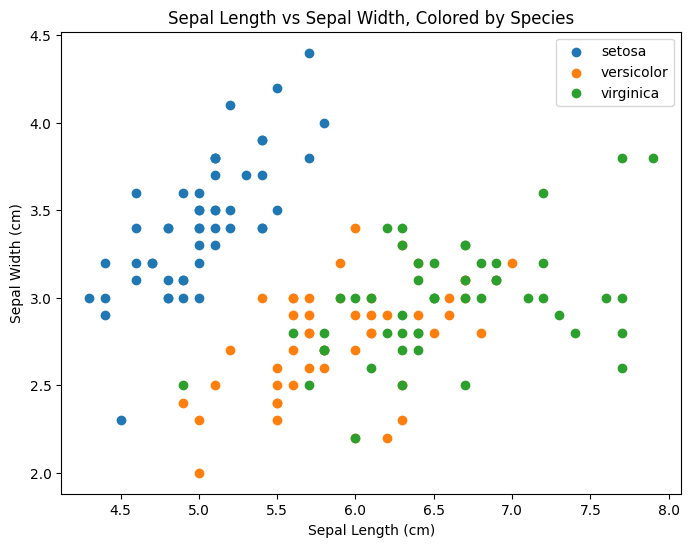

--------------------------------------------------------------------------------
╔══════════════════════════════════════════════════════════════════════════════════╗
║  🤔 Thought (Iteration 2)                                                          ║
╠══════════════════════════════════════════════════════════════════════════════════╣
║ The scatter plot of sepal length vs sepal width, colored by species, has been    ║
║ successfully generated. The plot displays the relationship between these two     ║
║ characteristics for each species of iris. By examining the plot, I can observe   ║
║ the distribution of points for each species and look for any patterns, such as   ║
║ clustering or separation, that might indicate differences between the species.   ║
║ This visualization can help inform further analysis, such as determining which   ║
║ features are most important for distinguishing between species or identifying    ║
║ potential outliers. Next, I would like to examine the distribution

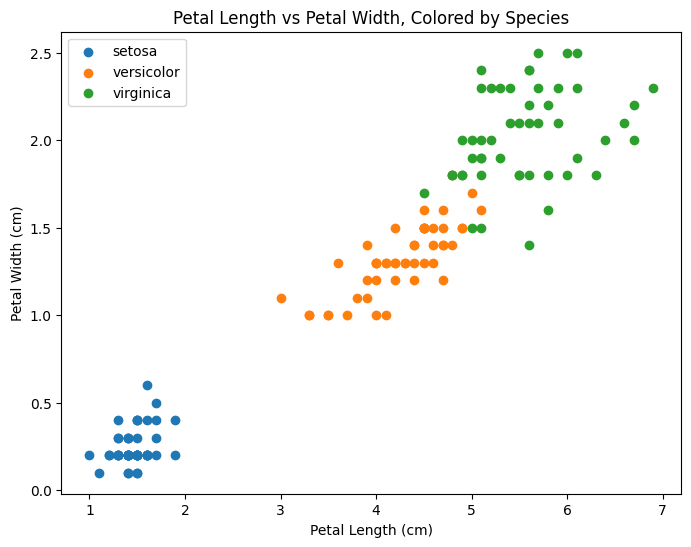

--------------------------------------------------------------------------------
╔══════════════════════════════════════════════════════════════════════════════════╗
║  🤔 Thought (Iteration 3)                                                          ║
╠══════════════════════════════════════════════════════════════════════════════════╣
║ The scatter plot of petal length vs petal width, colored by species, has been    ║
║ successfully generated. By comparing this plot with the previous one, I can      ║
║ observe that the species are more clearly separated in the petal length vs petal ║
║ width plot than in the sepal length vs sepal width plot. This suggests that      ║
║ petal length and petal width might be more important features for distinguishing ║
║ between the different species of iris. The plot also shows that Iris setosa is   ║
║ well-separated from the other two species, while Iris versicolor and Iris        ║
║ virginica are closer together but still somewhat distinct. This vi

In [12]:
query_1 = "Load the iris dataset and create a scatter plot of sepal length vs sepal width, colored by species"

print("=" * 80)
print("🌸 EXAMPLE 1: Iris Dataset Visualization")
print("=" * 80)
print(f"Task: {query_1}")
print()

result_1 = run_data_science_task(query_1)

Key observations from the above task:
- The agent automatically imports necessary libraries
- It explores the data structure before creating visualizations
- Error handling if the dataset isn't immediately available
- Proper use of color coding for categorical variables

## Machine Learning Pipeline

🤖 EXAMPLE 2: Machine Learning Pipeline
Task: 
1. Build a classification model to predict the species of the iris dataset
2. Show a confusion matrix plot
3. Provide the ROC curve plots for each class


🚀 Starting ReAct Data Science Agent
📝 Task: 
1. Build a classification model to predict the species of the iris dataset
2. Show a confusion matrix plot
3. Provide the ROC curve plots for each class

╔═══════════════════════════════════════════════════════════════════════════════╗
║  🤔 Thought (Iteration 1)                                                       ║
╠═══════════════════════════════════════════════════════════════════════════════╣
║ To start building a classification model for the iris dataset, I need to load ║
║ the necessary libraries, including pandas for data manipulation, numpy for    ║
║ numerical computations, matplotlib and seaborn for plotting, and scikit-learn ║
║ for the classification model. I also need to load the iris dataset.           ║
╚════════════════════════

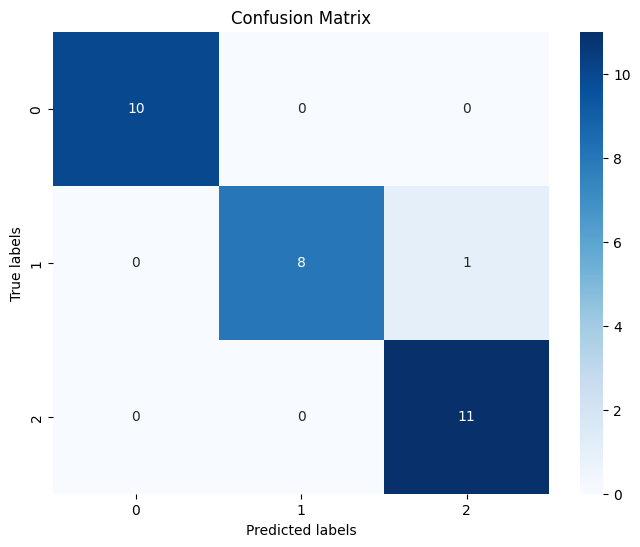

--------------------------------------------------------------------------------
╔══════════════════════════════════════════════════════════════════════════════════╗
║  🤔 Thought (Iteration 5)                                                          ║
╠══════════════════════════════════════════════════════════════════════════════════╣
║ The confusion matrix and classification report indicate that the SVM classifier  ║
║ is performing well, with an accuracy of 0.97. The precision, recall, and F1      ║
║ score are also high for all three classes. Now, I will proceed with plotting the ║
║ ROC curves for each class. To do this, I need to use the `roc_curve` function    ║
║ from scikit-learn to calculate the false positive rate and true positive rate at ║
║ different thresholds. I will then plot these rates to visualize the ROC curves.  ║
╚══════════════════════════════════════════════════════════════════════════════════╝
╔═══════════════════════════════════════════════════════════════════

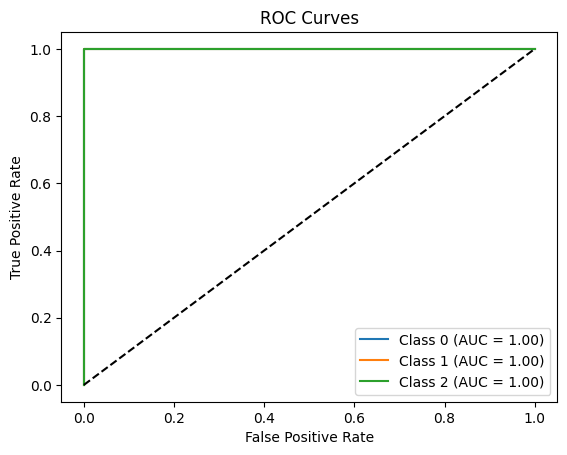

--------------------------------------------------------------------------------
╔═════════════════════════════════════════════════════════════════════════════════╗
║  🎯 Final Answer                                                                  ║
╠═════════════════════════════════════════════════════════════════════════════════╣
║ The classification model built using the SVM algorithm achieved an accuracy of  ║
║ 0.97 on the iris dataset. The confusion matrix and classification report showed ║
║ high precision, recall, and F1 scores for all three classes, indicating good    ║
║ performance. The ROC curves also demonstrated good separation between the       ║
║ classes. These results suggest that the SVM classifier is a suitable choice for ║
║ predicting the species of iris flowers based on their characteristics.          ║
╚═════════════════════════════════════════════════════════════════════════════════╝


In [ ]:
# Example 2: Complete ML pipeline with evaluation
query_2 = """
1. Build a classification model to predict the species of the iris dataset
2. Show a confusion matrix plot
3. Provide the ROC curve plots for each class
"""

print("=" * 80)
print("🤖 EXAMPLE 2: Machine Learning Pipeline")
print("=" * 80)
print(f"Task: {query_2}")
print()

# Run the agent
result_2 = run_data_science_task(query_2)


##  Exploratory Data Analysis on Custom Dataset


In [13]:
query_3 = "Help me perform EDA on the dataset stored in the file 'train_and_test2.csv'."

print("=" * 80)
print("📊 EXAMPLE 3: Exploratory Data Analysis on Custom Dataset")
print("=" * 80)
print(f"Task: {query_3}")
print()


data_directory = "./data"

result_3 = run_data_science_task(query_3, data_dir=data_directory)

📊 EXAMPLE 3: Exploratory Data Analysis on Custom Dataset
Task: Help me perform EDA on the dataset stored in the file 'train_and_test2.csv'.

📁 Collecting files from ./data...
📂 No valid files found in directory
🚀 Starting ReAct Data Science Agent
📝 Task: Help me perform EDA on the dataset stored in the file 'train_and_test2.csv'.
╔═════════════════════════════════════════════════════════════════════════════════╗
║  🤔 Thought (Iteration 1)                                                         ║
╠═════════════════════════════════════════════════════════════════════════════════╣
║ To begin the Exploratory Data Analysis (EDA), I need to load the necessary      ║
║ libraries and import the dataset from the file 'train_and_test2.csv'. This will ║
║ help me understand the structure and contents of the dataset.                   ║
╚═════════════════════════════════════════════════════════════════════════════════╝
╔═════════════════════════════════════════╗
║  🛠️ Action                       